In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scanpy.api as sc
import pandas as pd
import h5py
import os
import time
import itertools
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sceb.util import *
import sceb.data_loader as dl
import sceb.scdd as sd

%matplotlib inline
%load_ext autoreload
%autoreload 2

from matplotlib import rcParams

params = {
   'axes.labelsize': 16,
   'font.size': 16,
   'legend.fontsize': 10,
   'xtick.labelsize': 13,
   'ytick.labelsize': 13,
   'text.usetex': False,
   'text.usetex': False,
   }
rcParams.update(params)

output_folder = '/home/martin/single_cell_eb/figures/figure_network_example'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

/home/martin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
## load the data 
data = dl.load_10x_4k()
data.var_names_make_unique()
sc.pp.filter_genes(data,min_counts=0.00001*data.shape[0])
Nc,G,Nr,Nr_bar = sd.get_info(data)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
## Nc=4340, G=19773, Nr=4349.04, Nr_bar=0.22


In [3]:
## filter and calculate PC
size_factor = sd.dd_size_factor(data,verbose=False)
M_ml,M_dd = sd.dd_1d_moment(data,size_factor=size_factor)
var_dd = sd.M_to_var(M_dd)
gene_list = np.array(data.var_names)[var_dd>0.1]
data = data[:,list(gene_list)]

# calculate PC
mean_ml,cov_ml,PC_ml  = sd.ml_covariance(data,size_factor=size_factor)
mean_dd,cov_dd,PC_dd  = sd.dd_covariance(data,size_factor=size_factor,PC_prune=False)

#time start: 0.0s
n_cell=4340, n_gene=19773
#total: 0.31s
#time start: 0.0s
n_cell=4340, n_gene=791, Nr=3224.3
#total: 5.85s
#time start: 0.0s
n_cell=4340, n_gene=791, Nr=3224.3
#total: 3.71s


In [4]:
## marker gene
marker_gene_dic = {} 
marker_gene_dic['T-cells']= ['IL7R','CD3G','CD3E','CD3D','LCK']
marker_gene_dic['NK-cells']= ['NKG7','PRF1','KLRD1','GZMA','HOPX','CST7']
marker_gene_dic['B-cells']= ['CD79A','BANK1','IGHD','LINC00926','MS4A1']
marker_gene_dic['myeloid']= ['S100A8','S100A9','MNDA','FGL2','CLEC7A','CD6S','IFI30']
marker_gene_dic['Megakaryocytes']= ['PF4','PPBP']

markgenes_=[str(i) for sublist in marker_gene_dic.values() for i in sublist if i in gene_list]

# Correlation plot
Show the correlations of the marker genes with all other genes.

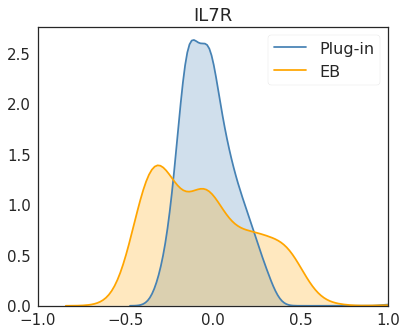

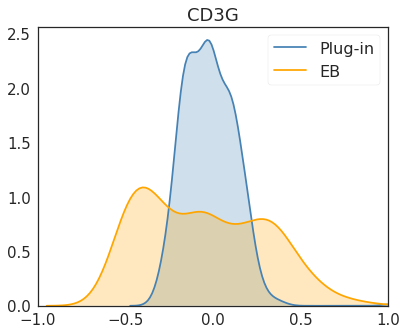

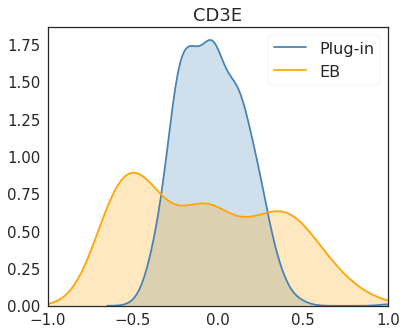

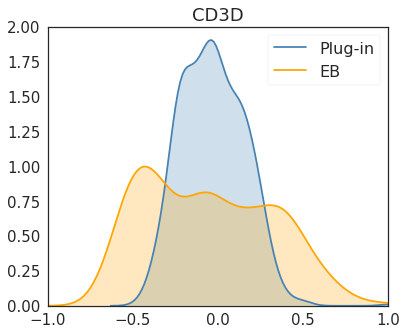

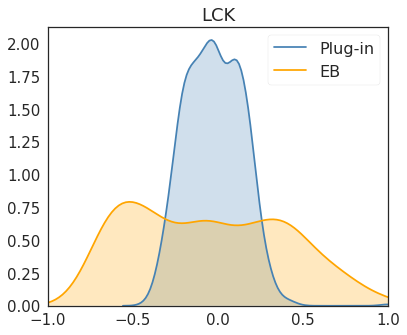

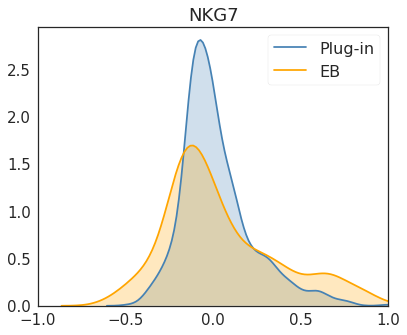

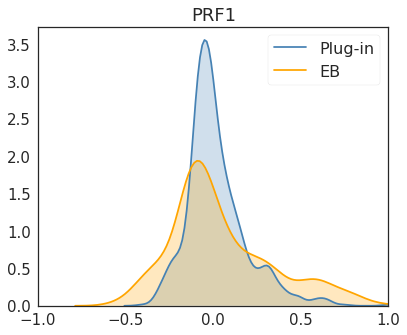

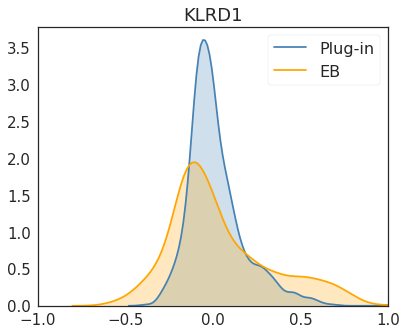

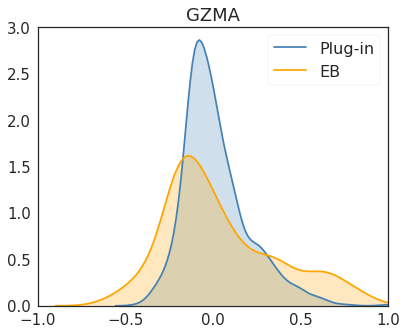

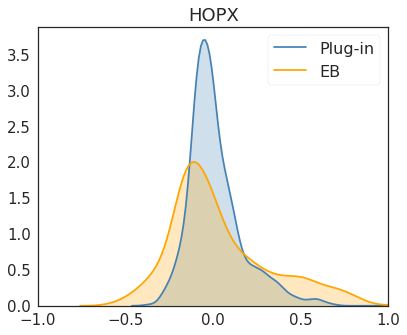

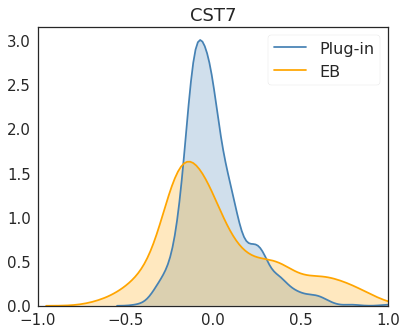

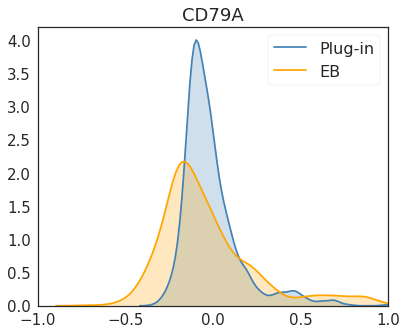

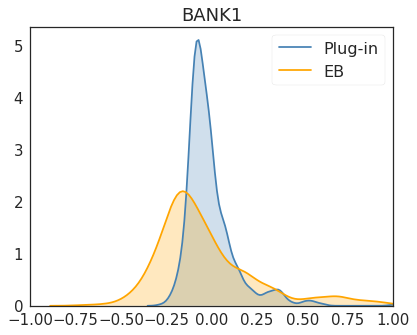

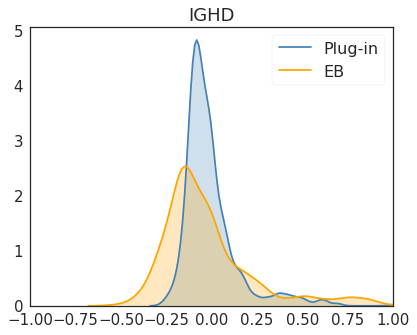

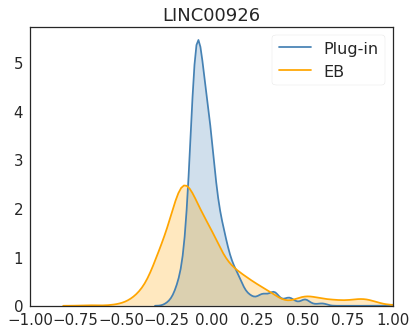

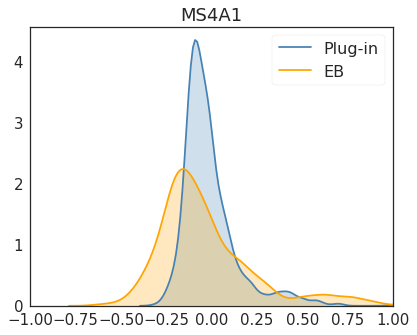

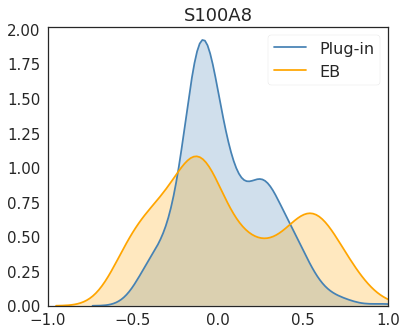

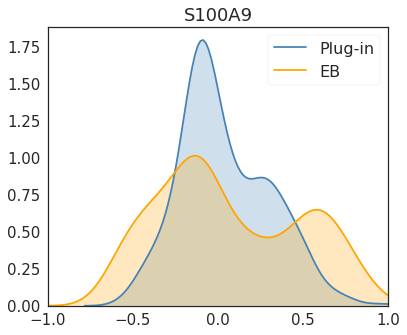

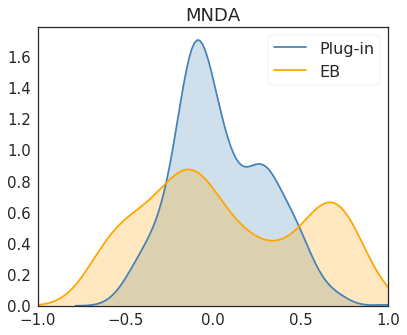

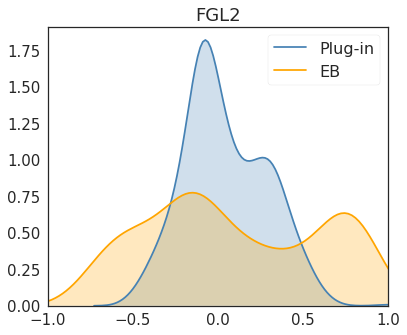

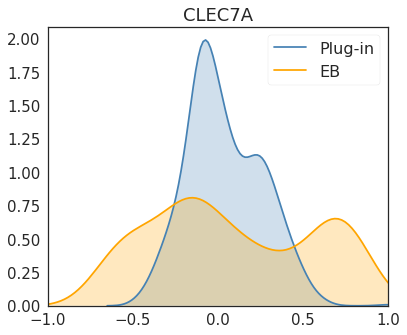

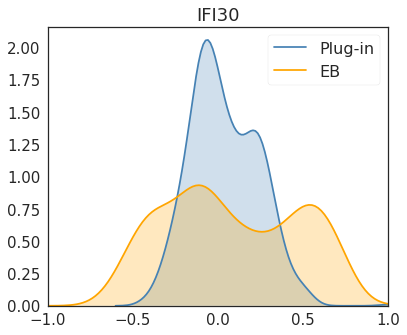

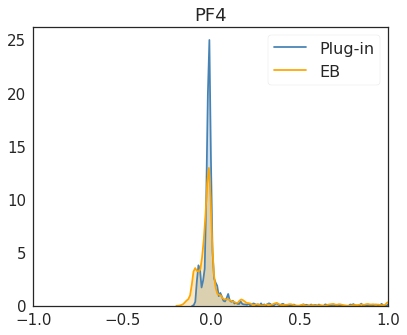

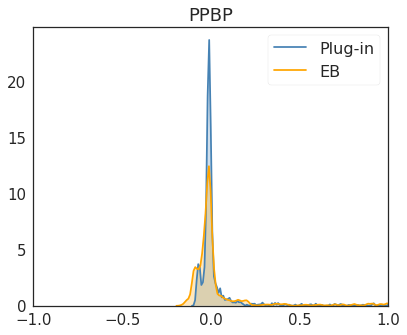

In [5]:
def plot_correlation(gene,gene_list,PC_ml,PC_dd,output_folder):
    loc = np.where(gene_list==gene)[0][0]
    plt.figure(figsize=(6,5))
    sns.set(font_scale=1.5)
    sns.set_style("white")
    sns.distplot(PC_ml[loc,:],label='Plug-in',hist=0,kde_kws={'shade':1},color='steelblue',)
    sns.distplot(PC_dd[loc,:],label='EB',hist=0,kde_kws={'shade':1},color='orange')
    plt.xlim([-1,1])
    plt.title(gene)
    plt.legend(fontsize=16,frameon=True)
    plt.savefig(output_folder+'/cor_%s.png'%gene)
    plt.savefig(output_folder+'/cor_%s.pdf'%gene)
    plt.tight_layout()
    plt.show()
    
for gene in markgenes_:
    plot_correlation(gene,gene_list,PC_ml,PC_dd,output_folder)


# Cases where EB and plug-in differ a lot

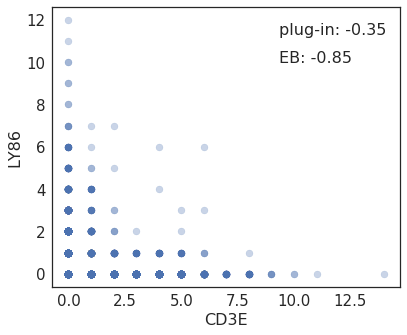

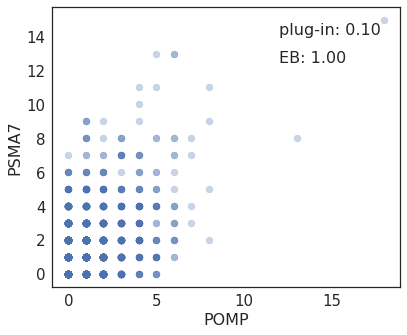

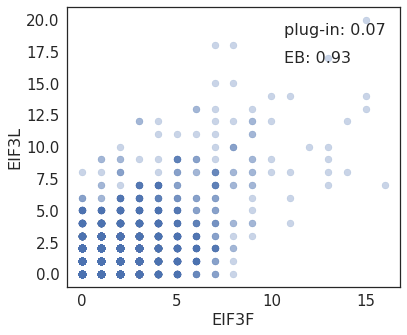

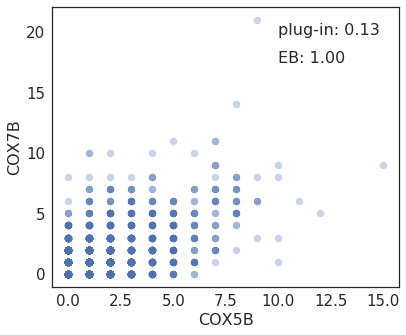

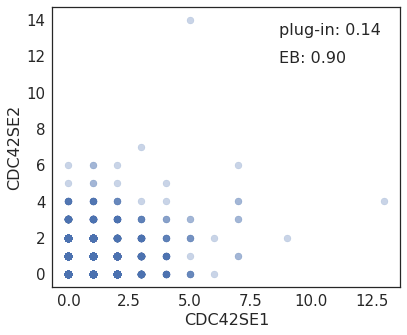

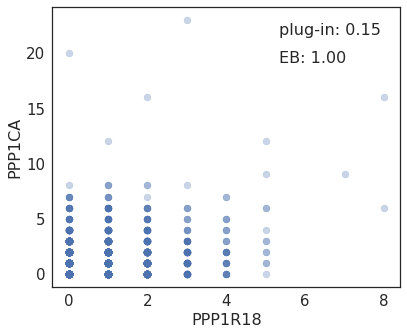

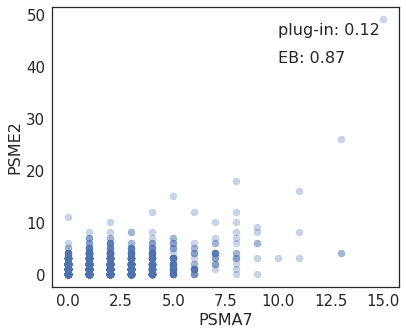

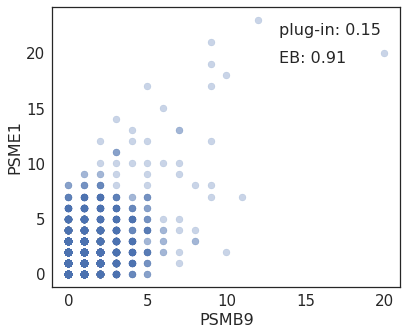

In [6]:
def plot_pairwise(gene1,gene2,gene_list,PC_dd,PC_ml,data,output_folder):
    loc1 = np.where(gene_list==gene1)[0][0]
    loc2 = np.where(gene_list==gene2)[0][0]
    
    x1 = np.array(data[:,gene1].X)
    x2 = np.array(data[:,gene2].X)

    plt.figure(figsize=(6,5))
    plt.scatter(x1,x2,alpha=0.3)
    plt.xlabel(gene1,fontsize=16)
    plt.ylabel(gene2,fontsize=16)
    xmin,xmax = plt.xlim()
    ymin,ymax = plt.ylim()
    plt.annotate('plug-in: %0.2f'%PC_ml[loc1,loc2], [xmin+0.65*(xmax-xmin),ymin+0.9*(ymax-ymin)], fontsize=16)
    plt.annotate('EB: %0.2f'%PC_dd[loc1,loc2], [xmin+0.65*(xmax-xmin),ymin+0.8*(ymax-ymin)], fontsize=16)
    
    plt.savefig(output_folder+'/pw_%s_%s.png'%(gene1,gene2))
    plt.savefig(output_folder+'/pw_%s_%s.pdf'%(gene1,gene2))
    plt.tight_layout()
    plt.show()
    


plot_list =[['CD3E','LY86'],['POMP','PSMA7'],['EIF3F' ,'EIF3L'],['COX5B','COX7B'],
            ['CDC42SE1', 'CDC42SE2'], ['PPP1R18','PPP1CA'], ['PSMA7' ,'PSME2'], 
            ['PSMB9', 'PSME1']]

# Vasilis's annotation
# plot_list =[['CD3E','LY86'],['POMP','PSMA7'],['PPP1R18','PPP1CA'],['PSMB9', 'DRAP1'],
#             ['PSMB9', 'ICAM3'],['RBM3', 'PSMA7'],['EIF3F' ,'EIF3L'],['CD53', 'PPP1CA'],
#             ['PSME2', 'PSMA7'],['TNFRSF1B', 'SERP1'],['CDC42SE1', 'CDC42SE2'],['COX5B', 'COX7B']]

for l in plot_list:
    gene1,gene2=l
    plot_pairwise(gene1,gene2,gene_list,PC_dd,PC_ml,data,output_folder)

# Comparison with String

In [12]:
from scipy.stats import hypergeom

analysis_string = np.loadtxt('/home/martin/single_cell_eb/figures/figure_gene_network\
/string_interactions_network.tsv',skiprows=1,dtype=str)
GT = np.zeros(PC_dd.shape)
for i in range(analysis_string.shape[0]):
    gene1 = analysis_string[i,0]
    gene2 = analysis_string[i,1]
    if (gene1 in gene_list) and (gene2 in gene_list):
        idx1 = np.where(gene_list == gene1)[0][0]
        idx2 = np.where(gene_list == gene2)[0][0]
        GT[idx1,idx2] = 1
        GT[idx2,idx1] = 1
GT = np.triu(GT)
# Cases where PC_dd and PC_ml differ significantly
temp = ((PC_dd - PC_ml)>0.7)*1
np.fill_diagonal(temp, 0)
temp = np.triu(temp)
sub_idx = (np.sum(temp,axis=0)>0)
sub_temp = temp[sub_idx,:][:,sub_idx]
sub_GT = GT[sub_idx,:][:,sub_idx]
# Calculate p-value 
n_esti_edge = np.sum(sub_temp)
n_match_edge = np.sum(sub_temp*sub_GT)
n_total = sub_GT.shape[0] * (sub_GT.shape[0]-1)/2
n_total_edge = np.sum(sub_GT)
p_value = 1 - hypergeom.cdf(n_match_edge, n_total, n_total_edge, n_esti_edge)
print('p-value = %s'%p_value)

p-value = 4.169553591282238e-11
